# Image Classification

모델이 데이터를 효율적으로 학습할 수 있도록 구현해보는게 목적입니다.

* Data augmentation을 이용해 오버피팅을 방지해봅시다.

기본적인 머신러닝 작업과정은 아래와 같습니다.

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

* 모델 완성 후 평가 지표에 따라서 모델을 평가해 봅시다.

## Project 설명
### Task
* 적은 수의 강아지와 고양이 사진을 이용해 classification을 진행해보자.
* 주어진 데이터를 Augmentation 하는 법과 딥러닝 트레이닝 과정을 구현해 보는것이 목표입니다.
* 데이터셋은 학습 데이터엔 강아지, 고양이 이미지 1000장이 있고, 테스트용 데이터에는 각각 500장씩 주어져있습니다.
    * 트레이닝 시 image size 조절해 사용

### Baseline
* 기본적으로 사용하는 Convolution layers를 구성해 사용해보자.
* 오버피팅을 방지하기 위한 다양한 방법들을 사용해보자.
    * Data Augmentation, Dropout, Batch Normalization
* Training
* Evaluation
    * 모델의 정확도와 크기를 이용해 점수를 제공하는 메트릭으로 평가해보자.

### Import packages

* 우리가 사용할 packages 를 import 하는 부분 입니다.
* 필요에 따른 packages를 선언합니다.
* 모델 저장을 위해서 구글 드라이브를 마운트해줍니다.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, models, transforms

import os
import requests
import zipfile
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
use_colab = False
assert use_colab in [True, False]

### 데이터셋 다운로드

* 해당 데이터는 개와 고양이 데이터로 구성되어 있습니다.

In [3]:
if use_colab:
    root_path = './'
else:
    root_path = 'data/'
def download_and_extract(url, dest_path):
    # 파일 이름 추출
    filename = url.split('/')[-1]
    file_path = os.path.join(dest_path, filename)

    # 파일이 이미 존재하지 않는 경우 다운로드
    if not os.path.exists(file_path):
        response = requests.get(url)
        with open(file_path, 'wb') as file:
            file.write(response.content)

    # 파일이 zip 파일인 경우 압축 해제
    if file_path.endswith('.zip'):
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall(dest_path)

# 사용 예시
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
download_and_extract(_URL, root_path)

### cats_and_dogs_filtered
* |__ train
    * |______ cats: [cat.0.jpg, cat.1.jpg, cat.2.jpg ....]
    * |______ dogs: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
* |__ validation
    * |______ cats: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....]
    * |______ dogs: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]

# 데이터셋 설정
* 다운로드 받은 데이터셋에 대한 경로를 이용하여, 데이터를 이용할 준비를 진행합니다.

In [4]:
if use_colab:
    PATH = '/content/cats_and_dogs_filtered'
else:
    PATH = 'data/cats_and_dogs_filtered/'
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [5]:
# directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

* 데이터셋의 구성을 살펴봅시다.

In [6]:
num_cats_tr = len(os.listdir(train_cats_dir))
print('total training cat images:', num_cats_tr)
num_dogs_tr = len(os.listdir(train_dogs_dir))
print('total training dog images:', num_dogs_tr)

print("--")

num_cats_val = len(os.listdir(validation_cats_dir))
print('total validation cat images:', num_cats_val)
num_dogs_val = len(os.listdir(validation_dogs_dir))
print('total validation dog images:', num_dogs_val)

print("--")

total_train = num_cats_tr + num_dogs_tr
print("Total training images:", total_train)
total_val = num_cats_val + num_dogs_val
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
--
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


* 학습 데이터는 고양이와 강아지 이미지 각각 1000 장씩으로 구성되어있습니다.
* 모델 평가를 위해서 각각 500장씩을 validation dataset으로 사용합니다.

### Data preparation 데이터 준비


In [7]:
# 학습을 위해 데이터 증가(augmentation) 및 일반화(normalization)
# 검증을 위한 일반화
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
}

data_dir = PATH #'/content/cats_and_dogs_filtered'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'validation']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'validation']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
X, y = next(iter(dataloaders['train']))
X.shape, y.shape

(torch.Size([4, 3, 224, 224]), torch.Size([4]))

### 이미지 샘플 확인

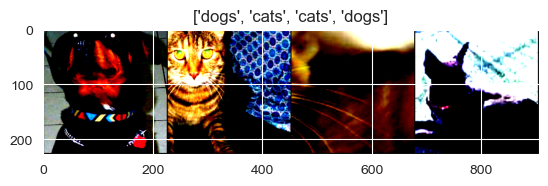

In [9]:
def imshow(inp, title=None):
    """tensor를 입력받아 일반적인 이미지로 보여줍니다."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# 모델 구현

* 직접 구현을 진행하거나 Transfer Learning을 진행할 수 있습니다.


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
print(num_features)
model.fc = nn.Linear(num_features, 2)
model = model.to(device)

512


In [11]:
from torchsummary import summary
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

# 모델 학습 진행
* 학습을 진행할때, train과 valid 데이터셋을 이용하여 학습과 검증을 동시에 진행합니다.
* 각 데이터셋은 위에서 구성했기 때문에, 모델에서 사용할 데이터의 step의 길이를 batch_size를 이용해 계산해줍니다.

In [12]:
import math
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch

        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [13]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=1e-10)

In [14]:
lr_scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=len(dataloaders['train'])*5, T_mult=1, eta_max=0.1,  T_up=10, gamma=0.5)

In [15]:
epoch = 100

min_loss = 9999
best_model = None

train_epoch_loss_list = []
valid_epoch_loss_list = []
lr_list = []
for epoch in range(epoch):   # 데이터셋을 수차례 반복합니다.

    train_loss_list = []
    model.train()
    for i, (images, labels) in enumerate(dataloaders['train']):
        images, labels = images.to(device), labels.to(device)

        preds = model(images)
        
        loss = criterion(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
     
        train_loss_list.append(loss.item())
        if ((epoch+1)*i)%10 == 0:
                lr_list.append(optimizer.param_groups[0]['lr'])
    loss = np.mean(train_loss_list)
    print(f'[{epoch + 1}] train loss: {loss:.4f}')
    train_epoch_loss_list.append(loss)
    
    valid_loss_list = []
    model.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloaders['validation']):
            images, labels = images.to(device), labels.to(device)
    
            preds = model(images)
            loss = criterion(preds, labels)
         
            valid_loss_list.append(loss.item())
    loss = np.mean(valid_loss_list)
    print(f'[{epoch + 1}] valid loss: {loss:.4f}')
    valid_epoch_loss_list.append(loss)
    if loss < min_loss:
        print(f'[{epoch +1}] best model!! save best model.')
        min_loss = loss
        best_model = model
    
print('Finished Training')

[1] train loss: 7.2332
[1] valid loss: 2.6073
[1] best model!! save best model.
[2] train loss: 8.7647
[2] valid loss: 2.9294
[3] train loss: 6.7625
[3] valid loss: 1.7482
[3] best model!! save best model.
[4] train loss: 4.0967
[4] valid loss: 1.7892
[5] train loss: 2.4788
[5] valid loss: 1.6604
[5] best model!! save best model.
[6] train loss: 5.7607
[6] valid loss: 3.5335
[7] train loss: 5.4247
[7] valid loss: 1.3980
[7] best model!! save best model.
[8] train loss: 4.1786
[8] valid loss: 2.4611
[9] train loss: 3.2189
[9] valid loss: 1.5379
[10] train loss: 2.1419
[10] valid loss: 1.6931
[11] train loss: 3.4037
[11] valid loss: 1.4299
[12] train loss: 3.0045
[12] valid loss: 1.2745
[12] best model!! save best model.
[13] train loss: 2.3952
[13] valid loss: 1.1801
[13] best model!! save best model.
[14] train loss: 1.6229
[14] valid loss: 1.7647
[15] train loss: 1.5554
[15] valid loss: 2.1869
[16] train loss: 1.7723
[16] valid loss: 1.8476
[17] train loss: 2.1151
[17] valid loss: 1.5

tensor([[ 6.7008, -7.6843],
        [ 1.5145, -2.5647],
        [-3.2268,  1.9543],
        [-8.7319,  8.4125]]) tensor([0, 1, 1, 1])


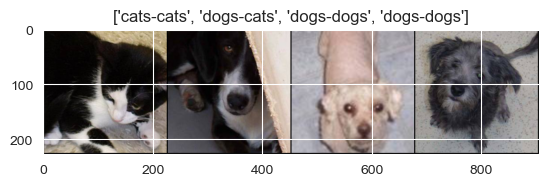

In [16]:
iterator = iter(dataloaders['validation'])
images, labels = next(iterator)
images = images.to(device)

preds = best_model(images).detach().cpu()
print(preds, labels)

out = torchvision.utils.make_grid(images.cpu())
imshow(out, title=[f'{class_names[y]}-{class_names[y_hat]}' for y,y_hat in zip(labels.cpu(), torch.max(preds,1)[1])])

<Axes: >

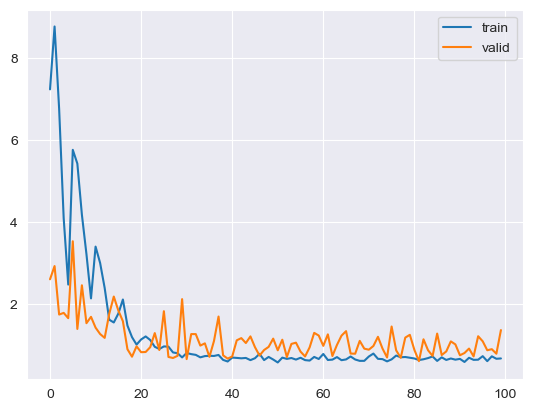

In [17]:
import seaborn as sns
sns.lineplot(train_epoch_loss_list, label='train')
sns.lineplot(valid_epoch_loss_list, label='valid')

<Axes: >

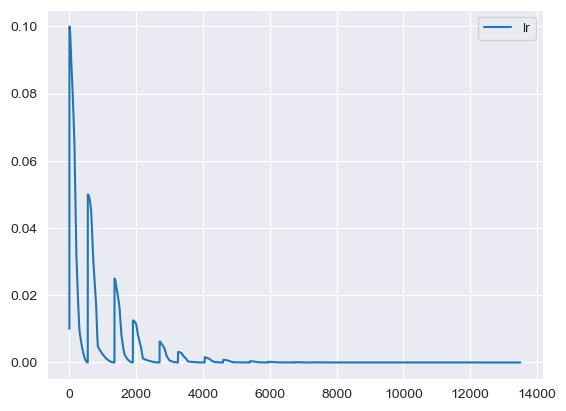

In [18]:
sns.lineplot(lr_list, label='lr')